# Random Subspace Control Analysis (Layer 25)

This notebook analyzes **random subspace interventions** as a **negative control**.

**Key Hypothesis**: Random subspace interventions should show **NULL effects** because:
- A random direction in activation space is not causally related to reasoning
- Add/Lesion/Rescue operations on random directions should not systematically affect accuracy
- P-values should be **non-significant** (p > 0.05)

Data source: `vm_results/random_results/`

This serves as a control comparison against the causal reasoning subspace results.

In [1]:
import sys
sys.path.insert(0, '../..')

from pathlib import Path
import re

import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import warnings

from evaluation import load_data, statistical_tests as st

warnings.filterwarnings('ignore')

# Base directories
VM_RESULTS_DIR = Path("../../vm_results/random_results/")
OUTPUT_DIR = Path("../outputs/random_subspace_control")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set up clean plotting style
plt.rcParams.update({
    'figure.figsize': (16, 8),
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.2,
})

print("Setup complete.")
print(f"Looking for experiments in: {VM_RESULTS_DIR.resolve()}")

Setup complete.
Looking for experiments in: /Users/washieu/Desktop/MIT/F25/64610_project/rvs/vm_results/random_results


## 1. Load Random Subspace Results

Load both COT and Answer locality experiments from the phase_b_random directory.

In [2]:
def parse_layer_value(val):
    """Convert layer value to integer, handling strings like 'L25'."""
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return int(val)
    if isinstance(val, str):
        match = re.search(r'(\d+)', str(val))
        if match:
            return int(match.group(1))
    return np.nan


def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Clean up the DataFrame, fixing column types."""
    df = df.copy()
    
    if 'layer' in df.columns:
        df['layer'] = df['layer'].apply(parse_layer_value)
    
    for col in ['alpha', 'gamma', 'beta']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df


def find_exp_dir(locality: str, base_dir: Path = VM_RESULTS_DIR) -> Path:
    """Find the experiment directory for a given locality.
    
    Expects names like:
        Qwen2.5-7B-Instruct__random_cot_locality_L25_YYYYMMDD_HHMMSS
        Qwen2.5-7B-Instruct__random_answer_locality_L25_YYYYMMDD_HHMMSS
    """
    # Try both patterns: experimental data (*__)
    patterns = [
        f"*__{locality}_locality_L25_*",  # random__ pattern
        f"*__random_{locality}_locality_L25_*",  # real data pattern
    ]
    for pattern in patterns:
        exp_dirs = sorted(base_dir.glob(pattern))
        if exp_dirs:
            exp_dir = exp_dirs[-1]  # Take the most recent
            print(f"Using {locality} experiment: {exp_dir}")
            return exp_dir
    raise FileNotFoundError(f"No experiment directory matching patterns {patterns} in {base_dir}")


def load_random_results(locality: str) -> pd.DataFrame:
    """Load all per-example results for a given locality."""
    exp_dir = find_exp_dir(locality)
    df = load_data.load_experiment_results(exp_dir)
    df = clean_dataframe(df)
    df['locality'] = locality
    return df


# Try to load both localities
dfs = []

try:
    cot_df = load_random_results('cot')
    print(f"\nCOT locality data: {len(cot_df)} rows")
    dfs.append(cot_df)
except FileNotFoundError as e:
    print(f"Warning: {e}")
    cot_df = pd.DataFrame()

try:
    answer_df = load_random_results('answer')
    print(f"Answer locality data: {len(answer_df)} rows")
    dfs.append(answer_df)
except FileNotFoundError as e:
    print(f"Warning: {e}")
    answer_df = pd.DataFrame()

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    print(f"\nTotal rows: {len(full_df)}")
else:
    raise ValueError("No data found in either locality!")

Using cot experiment: ../../vm_results/random_results/random__cot_locality_L25_20251205_221930

COT locality data: 900 rows
Using answer experiment: ../../vm_results/random_results/random__answer_locality_L25_20251205_221930
Answer locality data: 900 rows

Total rows: 1800


## 2. Data Summary

Check what modes and parameters are available in the random subspace data.

In [3]:
print("=== Data Structure ===")
print(f"Columns: {list(full_df.columns)}")
print(f"\nModes: {sorted(full_df['mode'].unique())}")
print(f"Layers: {sorted(full_df['layer'].dropna().unique())}")
print(f"Localities: {sorted(full_df['locality'].unique())}")

if 'alpha' in full_df.columns:
    print(f"Alpha values: {sorted(full_df['alpha'].dropna().unique())}")
if 'gamma' in full_df.columns:
    print(f"Gamma values: {sorted(full_df['gamma'].dropna().unique())}")
if 'beta' in full_df.columns:
    print(f"Beta values: {sorted(full_df['beta'].dropna().unique())}")

print("\n=== Row Counts by Mode ===")
display(full_df.groupby(['locality', 'mode']).size().reset_index(name='count'))

=== Data Structure ===
Columns: ['example_id', 'baseline_answer_correct', 'intv_answer_correct', 'experiment_type', 'mode', 'layer', 'gamma', 'locality', 'source_file', 'alpha', 'lesion_answer_correct', 'rescue_answer_correct', 'beta', 'dataset', 'model', 'experiment_name']

Modes: ['add', 'lesion', 'rescue']
Layers: [np.int64(25)]
Localities: ['answer', 'cot']
Alpha values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]
Gamma values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]
Beta values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]

=== Row Counts by Mode ===


,locality,mode,count
0,answer,add,300
1,answer,lesion,300
2,answer,rescue,300
3,cot,add,300
4,cot,lesion,300
5,cot,rescue,300


## 3. Statistical Analysis Functions

Define functions to compute McNemar's test and other statistics for paired and triplet data.

In [4]:
def summarize_paired_cell(
    df: pd.DataFrame,
    mode: str,
    layer: int,
    locality: str,
    param_col: str,
    param_value: float,
    param_type: str,
    metric: str = 'answer',
) -> dict:
    """Summarize one (mode, layer, locality, param) cell for paired data."""
    mask = (
        (df['mode'] == mode) &
        (df['layer'] == layer) &
        (df['locality'] == locality)
    )
    
    if param_col in df.columns:
        mask &= df[param_col] == param_value
    else:
        return _empty_paired_result(mode, layer, param_value, param_type, locality)

    cell = df[mask]

    if cell.empty:
        return _empty_paired_result(mode, layer, param_value, param_type, locality)

    base_col = f'baseline_{metric}_correct'
    intv_col = f'intv_{metric}_correct'
    if base_col not in cell.columns or intv_col not in cell.columns:
        print(f"Warning: missing columns {base_col} / {intv_col}")
        return _empty_paired_result(mode, layer, param_value, param_type, locality)

    c = cell.copy()
    for col in [base_col, intv_col]:
        if c[col].dtype == object:
            c[col] = c[col].map({'True': 1, 'False': 0, True: 1, False: 0})
        c[col] = pd.to_numeric(c[col], errors='coerce').fillna(0).astype(int)

    deltas = (c[intv_col] - c[base_col]).dropna()
    n = len(deltas)
    if n == 0:
        return _empty_paired_result(mode, layer, param_value, param_type, locality)

    # Run statistical tests
    wilcox = st.run_wilcoxon_test(c, metric=metric)
    ttest = st.run_ttest_vs_zero(c, metric=metric)
    sign_res = st.run_sign_test(c, metric=metric)
    mcnemar_res = st.run_mcnemar_test(c, metric=metric)

    return {
        'mode': mode,
        'layer': int(layer),
        'param_value': float(param_value),
        'param_type': param_type,
        'locality': locality,
        'n': int(n),
        'delta_mean': float(deltas.mean()),
        'delta_median': float(deltas.median()),
        'mcnemar_p': mcnemar_res.get('p_value', np.nan),
        'mcnemar_net_gain': mcnemar_res.get('net_gain', np.nan),
        'wilcoxon_p': wilcox.get('p_value', np.nan),
        'sign_p': sign_res.get('p_value', np.nan),
        'ttest_p': ttest.get('p_value', np.nan),
    }


def _empty_paired_result(mode, layer, param_value, param_type, locality):
    return {
        'mode': mode,
        'layer': int(layer),
        'param_value': float(param_value),
        'param_type': param_type,
        'locality': locality,
        'n': 0,
        'delta_mean': np.nan,
        'delta_median': np.nan,
        'mcnemar_p': np.nan,
        'mcnemar_net_gain': np.nan,
        'wilcoxon_p': np.nan,
        'sign_p': np.nan,
        'ttest_p': np.nan,
    }


def summarize_rescue_triplet(
    df: pd.DataFrame,
    layer: int,
    locality: str,
    gamma: float,
    beta: float,
) -> dict:
    """Summarize rescue triplet data (original, lesion, rescue)."""
    mask = (
        (df['mode'] == 'rescue') &
        (df['layer'] == layer) &
        (df['locality'] == locality) &
        (df['gamma'] == gamma) &
        (df['beta'] == beta)
    )
    
    cell = df[mask]
    
    if cell.empty:
        return _empty_rescue_result(layer, locality, gamma, beta)
    
    orig_col = 'baseline_answer_correct'
    lesion_col = 'lesion_answer_correct'
    rescue_col = 'rescue_answer_correct'
    
    if lesion_col not in cell.columns or rescue_col not in cell.columns:
        return _empty_rescue_result(layer, locality, gamma, beta)
    
    c = cell.copy()
    for col in [orig_col, lesion_col, rescue_col]:
        if c[col].dtype == object:
            c[col] = c[col].map({'True': 1, 'False': 0, True: 1, False: 0})
        c[col] = pd.to_numeric(c[col], errors='coerce').fillna(0).astype(int)
    
    n = len(c)
    
    acc_original = c[orig_col].mean()
    acc_lesion = c[lesion_col].mean()
    acc_rescue = c[rescue_col].mean()
    
    delta_lesion = acc_lesion - acc_original
    delta_rescue = acc_rescue - acc_lesion
    
    if acc_original > acc_lesion:
        recovery_rate = (acc_rescue - acc_lesion) / (acc_original - acc_lesion)
    else:
        recovery_rate = np.nan
    
    # McNemar test: lesion vs rescue
    lesion_wrong_rescue_right = ((c[lesion_col] == 0) & (c[rescue_col] == 1)).sum()
    lesion_right_rescue_wrong = ((c[lesion_col] == 1) & (c[rescue_col] == 0)).sum()
    
    if lesion_wrong_rescue_right + lesion_right_rescue_wrong > 0:
        try:
            res = scipy_stats.binomtest(
                min(lesion_wrong_rescue_right, lesion_right_rescue_wrong),
                lesion_wrong_rescue_right + lesion_right_rescue_wrong,
                0.5
            )
            mcnemar_rescue_p = res.pvalue
        except:
            mcnemar_rescue_p = np.nan
    else:
        mcnemar_rescue_p = np.nan
    
    return {
        'mode': 'rescue',
        'layer': int(layer),
        'param_value': float(beta),
        'param_type': 'beta',
        'locality': locality,
        'gamma': float(gamma),
        'n': int(n),
        'acc_original': float(acc_original),
        'acc_lesion': float(acc_lesion),
        'acc_rescue': float(acc_rescue),
        'delta_lesion': float(delta_lesion),
        'delta_rescue': float(delta_rescue),
        'recovery_rate': float(recovery_rate) if not np.isnan(recovery_rate) else np.nan,
        'mcnemar_rescue_p': float(mcnemar_rescue_p) if not np.isnan(mcnemar_rescue_p) else np.nan,
    }


def _empty_rescue_result(layer, locality, gamma, beta):
    return {
        'mode': 'rescue',
        'layer': int(layer),
        'param_value': float(beta),
        'param_type': 'beta',
        'locality': locality,
        'gamma': float(gamma),
        'n': 0,
        'acc_original': np.nan,
        'acc_lesion': np.nan,
        'acc_rescue': np.nan,
        'delta_lesion': np.nan,
        'delta_rescue': np.nan,
        'recovery_rate': np.nan,
        'mcnemar_rescue_p': np.nan,
    }

print("Statistical functions defined.")

Statistical functions defined.


## 4. Compute Statistics for Add/Lesion

Compute paired statistics for Add and Lesion modes at Layer 25.

In [5]:
# Get available modes and parameters
paired_df = full_df[full_df['mode'].isin(['add'])].copy()
lesion_df = full_df[full_df['mode'] == 'lesion'].copy()
rescue_df = full_df[full_df['mode'] == 'rescue'].copy()

localities = sorted(full_df['locality'].unique())
layer = 25  # Only layer 25

# Get available parameter values
alphas = sorted(full_df['alpha'].dropna().unique()) if 'alpha' in full_df.columns else [0.5, 1.0, 2.0]
gammas = sorted(full_df['gamma'].dropna().unique()) if 'gamma' in full_df.columns else [0.5, 1.0, 2.0]
betas = sorted(full_df['beta'].dropna().unique()) if 'beta' in full_df.columns else [0.5, 1.0]

print(f"Localities: {localities}")
print(f"Layer: {layer}")
print(f"Alpha values: {alphas}")
print(f"Gamma values: {gammas}")
print(f"Beta values: {betas}")

Localities: ['answer', 'cot']
Layer: 25
Alpha values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]
Gamma values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]
Beta values: [np.float64(0.5), np.float64(1.0), np.float64(2.0)]


In [6]:
paired_rows = []
rescue_rows = []

# === Add mode (paired) ===
for locality in localities:
    for alpha in alphas:
        row = summarize_paired_cell(
            df=paired_df,
            mode='add',
            layer=layer,
            locality=locality,
            param_col='alpha',
            param_value=float(alpha),
            param_type='alpha',
        )
        if row['n'] > 0:
            paired_rows.append(row)

# === Lesion mode (paired) ===
for locality in localities:
    for gamma in gammas:
        row = summarize_paired_cell(
            df=lesion_df,
            mode='lesion',
            layer=layer,
            locality=locality,
            param_col='gamma',
            param_value=float(gamma),
            param_type='gamma',
        )
        if row['n'] > 0:
            paired_rows.append(row)

# === Rescue mode (triplet) ===
if not rescue_df.empty:
    for locality in localities:
        for gamma in [0.5]:  # Usually fixed gamma for rescue
            for beta in betas:
                row = summarize_rescue_triplet(
                    df=rescue_df,
                    layer=layer,
                    locality=locality,
                    gamma=gamma,
                    beta=float(beta),
                )
                if row['n'] > 0:
                    rescue_rows.append(row)

paired_summary = pd.DataFrame(paired_rows)
rescue_summary = pd.DataFrame(rescue_rows)

print(f"\nPaired summary (Add/Lesion): {len(paired_summary)} rows")
print(f"Rescue triplet summary: {len(rescue_summary)} rows")


Paired summary (Add/Lesion): 12 rows
Rescue triplet summary: 6 rows


## 5. Display Results - Add/Lesion

**Expected: Near-zero deltas, p > 0.05 (not significant)**

In [7]:
print("=== Random Subspace: Add/Lesion Statistics ===")
print("\nExpected: Delta ≈ 0, p > 0.05 (NULL effect)\n")

if not paired_summary.empty:
    # Add significance indicator
    paired_summary['significant'] = paired_summary['mcnemar_p'].apply(
        lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    )
    
    display_cols = ['mode', 'locality', 'param_value', 'n', 'delta_mean', 'mcnemar_p', 'significant']
    display(paired_summary[display_cols].sort_values(['locality', 'mode', 'param_value']))
    
    # Count significant results
    n_significant = (paired_summary['mcnemar_p'] < 0.05).sum()
    n_total = len(paired_summary)
    print(f"\n⚠️ Significant results: {n_significant}/{n_total}")
    if n_significant == 0:
        print("✅ Good! No significant effects detected (as expected for random control).")
    else:
        print("⚠️ Warning: Some significant results found. May be due to chance (Type I error).")
else:
    print("No Add/Lesion data available.")

=== Random Subspace: Add/Lesion Statistics ===

Expected: Delta ≈ 0, p > 0.05 (NULL effect)



,mode,locality,param_value,n,delta_mean,mcnemar_p,significant
0,add,answer,0.5,100,-0.02,0.687500,
1,add,answer,1.0,100,-0.02,0.753906,
2,add,answer,2.0,100,0.03,0.453125,
6,lesion,answer,0.5,100,-0.01,1.000000,
7,lesion,answer,1.0,100,0.03,0.375000,
8,lesion,answer,2.0,100,-0.03,0.375000,
3,add,cot,0.5,100,0.04,0.125000,
4,add,cot,1.0,100,-0.03,0.507812,
5,add,cot,2.0,100,0.06,0.031250,*
9,lesion,cot,0.5,100,0.01,1.000000,



⚠️ Significant results: 1/12
⚠️ Warning: Some significant results found. May be due to chance (Type I error).


## 6. Display Results - Rescue Triplet

**Expected: No systematic recovery (delta_rescue ≈ 0, p > 0.05)**

In [8]:
print("=== Random Subspace: Rescue Triplet Statistics ===")
print("\nExpected: No recovery effect (p > 0.05)\n")

if not rescue_summary.empty:
    rescue_summary['significant'] = rescue_summary['mcnemar_rescue_p'].apply(
        lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    )
    
    display_cols = ['locality', 'gamma', 'param_value', 'n', 'acc_original', 'acc_lesion', 
                   'acc_rescue', 'delta_rescue', 'mcnemar_rescue_p', 'significant']
    display(rescue_summary[display_cols])
else:
    print("No Rescue triplet data available.")

=== Random Subspace: Rescue Triplet Statistics ===

Expected: No recovery effect (p > 0.05)



,locality,gamma,param_value,n,acc_original,acc_lesion,acc_rescue,delta_rescue,mcnemar_rescue_p,significant
0,answer,0.5,0.5,100,0.38,0.39,0.41,0.02,0.6250,
1,answer,0.5,1.0,100,0.37,0.39,0.41,0.02,0.6250,
2,answer,0.5,2.0,100,0.29,0.30,0.31,0.01,1.0000,
3,cot,0.5,0.5,100,0.36,0.37,0.37,0.00,1.0000,
4,cot,0.5,1.0,100,0.37,0.37,0.35,-0.02,0.6875,
5,cot,0.5,2.0,100,0.30,0.32,0.33,0.01,1.0000,


## 7. Visualization - Add/Lesion Heatmap

In [9]:
def format_pvalue(p: float) -> str:
    if pd.isna(p):
        return 'p=N/A'
    elif p < 0.001:
        return 'p<.001'
    elif p < 0.01:
        return f'p={p:.3f}'
    else:
        return f'p={p:.2f}'


def get_significance_stars(p: float) -> str:
    if pd.isna(p):
        return ''
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''


def plot_random_control_grid(
    data: pd.DataFrame,
    locality: str,
    layer: int = 25,
    title: str = None,
    save_path: Path = None,
    figsize: tuple = (20, 10)
) -> plt.Figure:
    """Create a 1×2 grid showing Add and Lesion effects for random subspace.
    
    Color scale is tight around 0 since we expect null effects.
    """
    modes = ['add', 'lesion']
    mode_labels = {'add': 'Add (α) - Random', 'lesion': 'Lesion (γ) - Random'}
    
    data_loc = data[(data['locality'] == locality) & (data['layer'] == layer)]
    if data_loc.empty:
        print(f"No data for locality={locality}, layer={layer}")
        return None

    # Tight color scale for null effects (±0.10)
    abs_max = 0.10

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, len(modes) + 1, width_ratios=[1] * len(modes) + [0.1], wspace=0.25)

    cmap = sns.diverging_palette(10, 130, as_cmap=True)
    norm = TwoSlopeNorm(vmin=-abs_max, vcenter=0, vmax=abs_max)

    for col_idx, mode in enumerate(modes):
        ax = fig.add_subplot(gs[0, col_idx])
        cell_data = data_loc[data_loc['mode'] == mode]

        # Get parameter values
        params_cfg = sorted(cell_data['param_value'].unique()) if not cell_data.empty else [0.5, 1.0, 2.0]
        
        values = []
        pvalues = []
        for p in params_cfg:
            row = cell_data[cell_data['param_value'] == p]
            if len(row) > 0:
                val = row['delta_mean'].values[0]
                values.append(val if not pd.isna(val) else 0.0)
                pvalues.append(row['mcnemar_p'].values[0] if 'mcnemar_p' in row.columns else np.nan)
            else:
                values.append(0.0)
                pvalues.append(np.nan)

        heatmap_data = np.array([values])
        im = ax.imshow(heatmap_data, cmap=cmap, norm=norm, aspect='auto')

        # Add value annotations with p-values
        for i, (val, pval) in enumerate(zip(values, pvalues)):
            text_color = 'white' if abs(val) > abs_max * 0.5 else 'black'
            stars = get_significance_stars(pval)
            is_significant = pval < 0.05 if not pd.isna(pval) else False

            delta_text = f'{val:+.2f}{stars}'
            fontweight = 'bold' if is_significant else 'semibold'
            ax.text(i, -0.15, delta_text, ha='center', va='center',
                    fontsize=12, color=text_color, fontweight=fontweight)

            pval_text = format_pvalue(pval)
            pval_fontweight = 'bold' if is_significant else 'normal'
            ax.text(i, 0.25, pval_text, ha='center', va='center',
                    fontsize=10, color=text_color, fontweight=pval_fontweight)

        ax.set_xticks(range(len(params_cfg)))
        ax.set_yticks([])
        ax.set_xticklabels([str(p) for p in params_cfg], fontsize=11)
        ax.set_xlabel('Parameter Value (α / γ)', fontsize=12)
        ax.set_title(mode_labels.get(mode, mode), fontsize=14, fontweight='bold', pad=12)

        if col_idx == 0:
            ax.set_ylabel(f'Layer {layer}', fontsize=13, fontweight='bold')

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('#cccccc')

    # Add colorbar
    cbar_ax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Δ Answer Accuracy\n(Intervention − Baseline)', fontsize=11, labelpad=12)
    cbar.ax.tick_params(labelsize=10)

    if title is None:
        title = f'Random Subspace Control: {locality.upper()} Locality (Layer {layer})'
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)

    subtitle = (
        'CONTROL: Random subspace should show NULL effects\n'
        'Expected: Δ ≈ 0, p > 0.05 (not significant)\n'
        "p-values: McNemar's Test | * p<0.05, ** p<0.01, *** p<0.001"
    )
    fig.text(0.5, 0.95, subtitle, ha='center', fontsize=10, style='italic', color='#555555')

    plt.tight_layout(rect=[0, 0, 1, 0.85])

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")

    return fig

print("Plotting function defined.")

Plotting function defined.


Saved to ../outputs/random_subspace_control/random_control_cot_locality.pdf


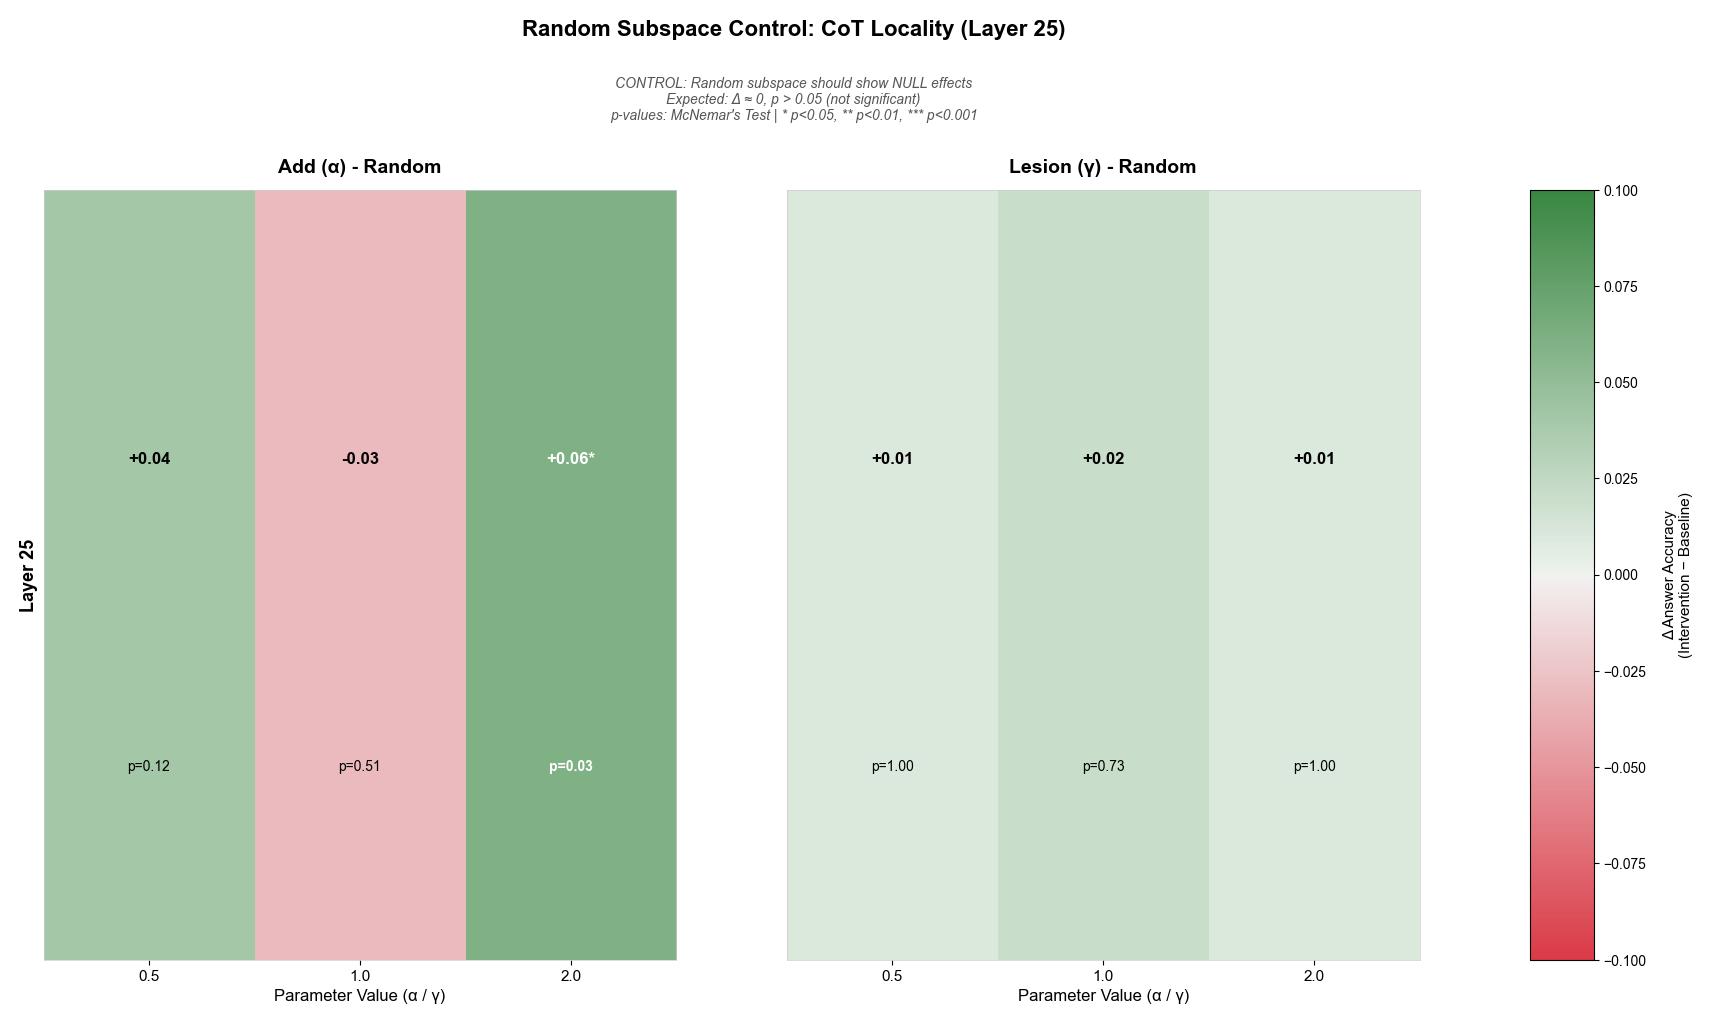

In [10]:
# Plot COT locality
if not paired_summary.empty and 'cot' in paired_summary['locality'].unique():
    fig_cot = plot_random_control_grid(
        paired_summary,
        locality='cot',
        layer=25,
        title='Random Subspace Control: CoT Locality (Layer 25)',
        save_path=OUTPUT_DIR / 'random_control_cot_locality.pdf',
    )
    plt.show()
else:
    print("No COT locality data available.")

Saved to ../outputs/random_subspace_control/random_control_answer_locality.pdf


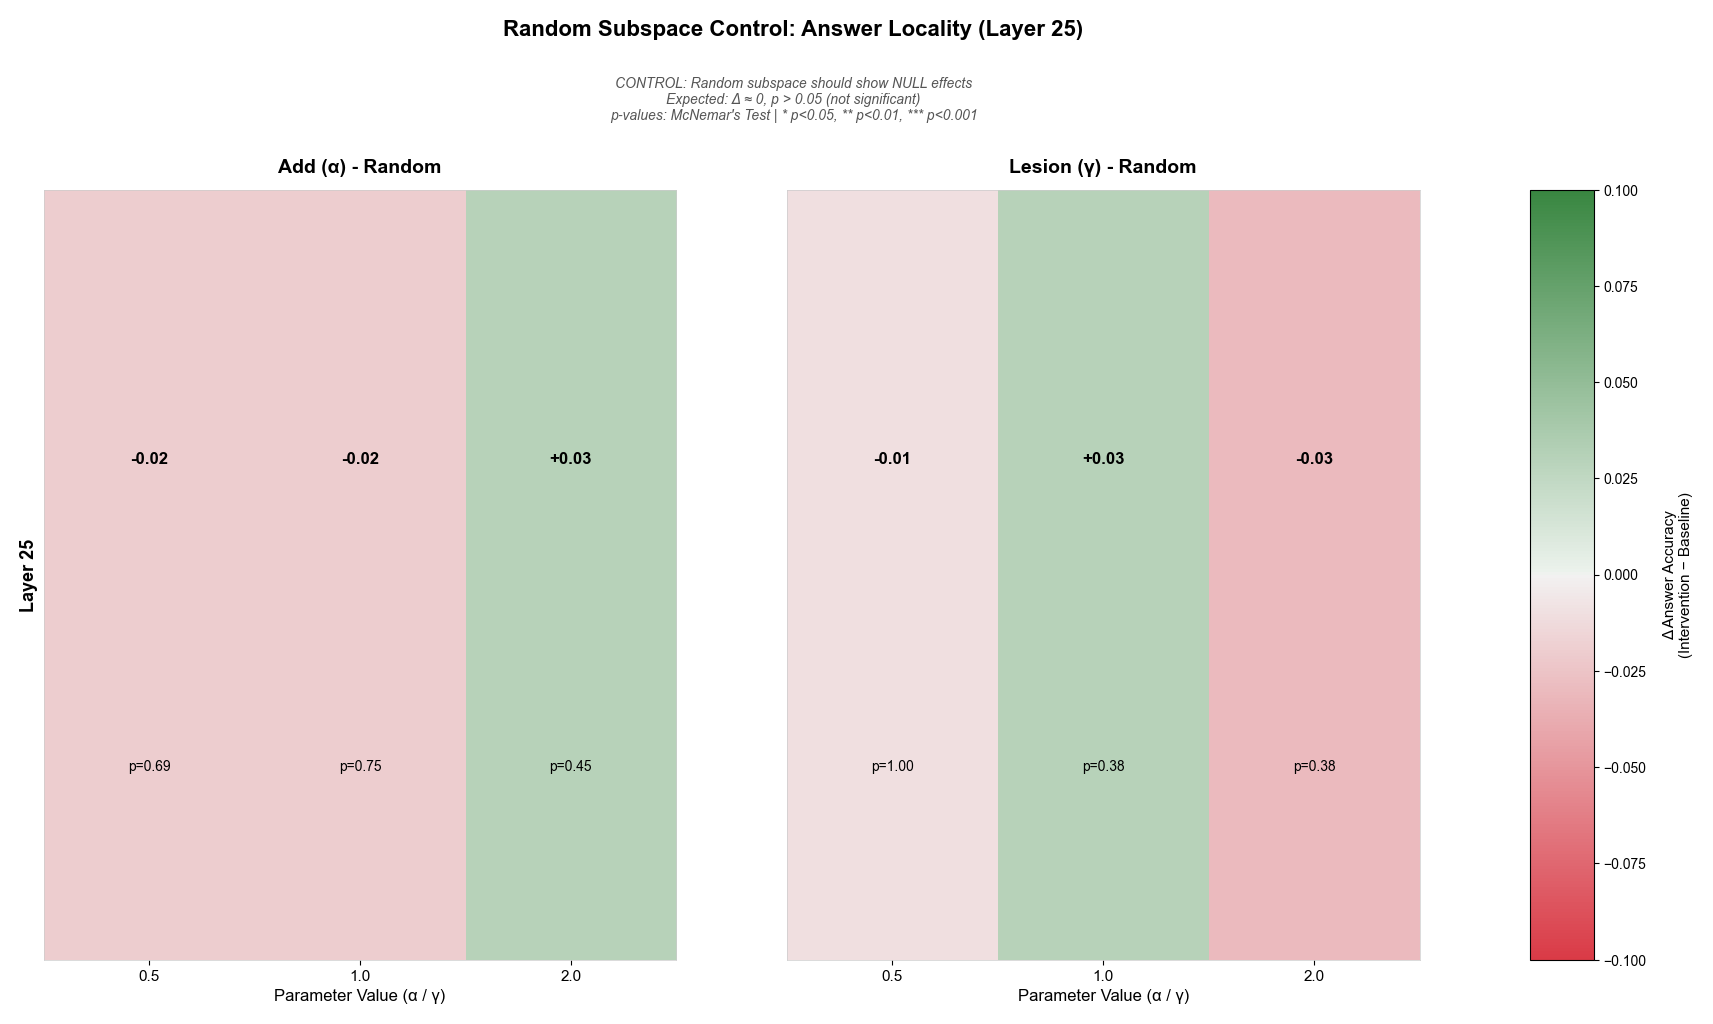

In [11]:
# Plot Answer locality
if not paired_summary.empty and 'answer' in paired_summary['locality'].unique():
    fig_answer = plot_random_control_grid(
        paired_summary,
        locality='answer',
        layer=25,
        title='Random Subspace Control: Answer Locality (Layer 25)',
        save_path=OUTPUT_DIR / 'random_control_answer_locality.pdf',
    )
    plt.show()
else:
    print("No Answer locality data available.")

## 8. Visualization - Rescue Triplet

Saved to ../outputs/random_subspace_control/random_rescue_triplet_answer.pdf


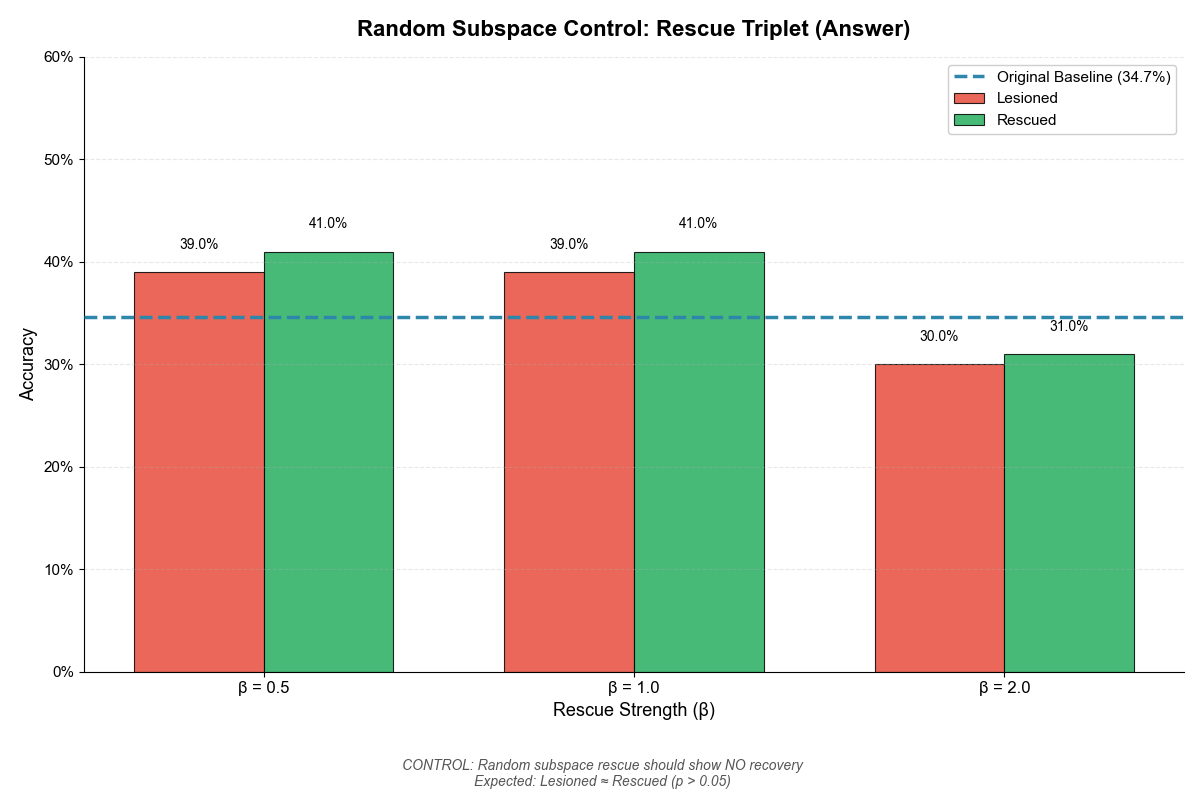

Saved to ../outputs/random_subspace_control/random_rescue_triplet_cot.pdf


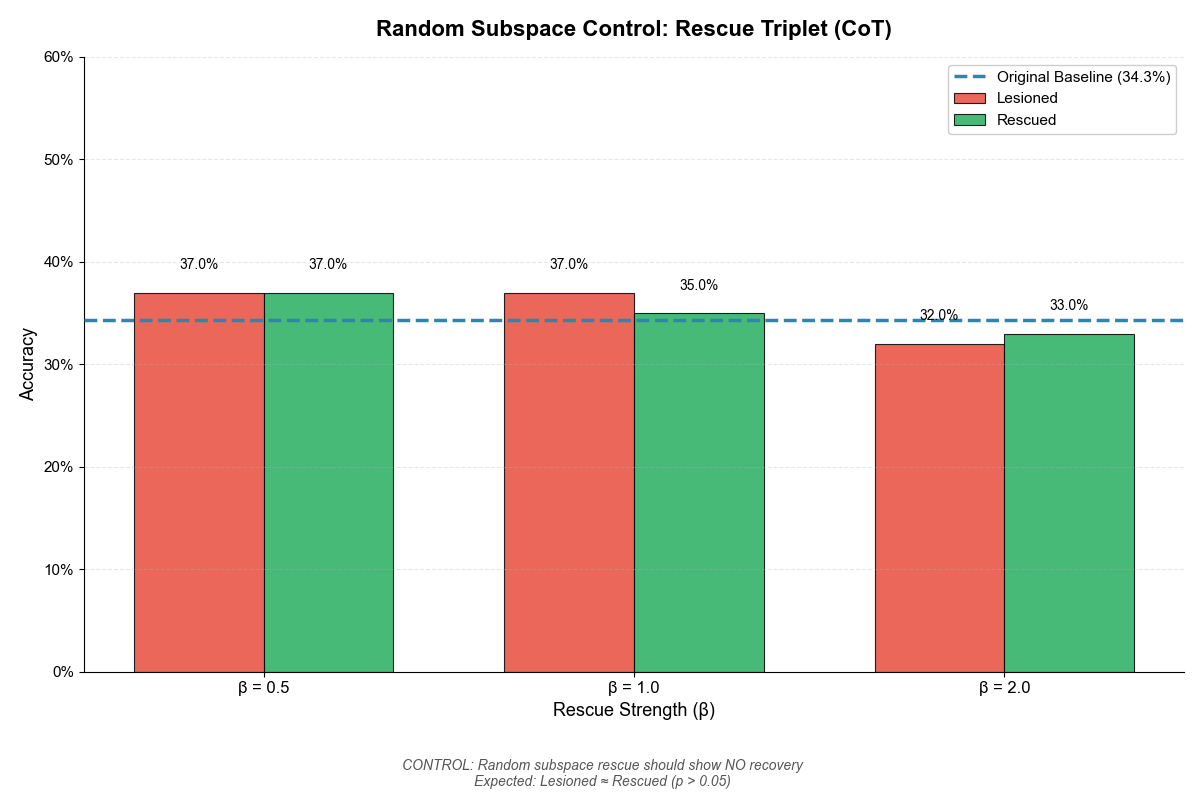

In [16]:
def plot_rescue_triplet_random(
    data: pd.DataFrame,
    locality: str,
    title: str = None,
    save_path: Path = None,
    figsize: tuple = (12, 8)
) -> plt.Figure:
    """Plot rescue triplet for random subspace control."""
    loc_data = data[data['locality'] == locality].copy()
    if loc_data.empty:
        print(f"No rescue data for locality={locality}")
        return None
    
    betas = sorted(loc_data['param_value'].unique())
    n_betas = len(betas)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    original_acc = loc_data['acc_original'].mean()
    
    ax.axhline(y=original_acc, color='#2E86AB', linestyle='--', linewidth=2.5, 
               label=f'Original Baseline ({original_acc:.1%})', zorder=3)
    
    x = np.arange(n_betas)
    width = 0.35
    
    lesion_accs = []
    rescue_accs = []
    rescue_pvals = []
    
    for beta in betas:
        row = loc_data[loc_data['param_value'] == beta]
        if len(row) > 0:
            lesion_accs.append(row['acc_lesion'].values[0])
            rescue_accs.append(row['acc_rescue'].values[0])
            rescue_pvals.append(row['mcnemar_rescue_p'].values[0])
        else:
            lesion_accs.append(np.nan)
            rescue_accs.append(np.nan)
            rescue_pvals.append(np.nan)
    
    bars_lesion = ax.bar(x - width/2, lesion_accs, width, label='Lesioned', 
                          color='#E74C3C', alpha=0.85, edgecolor='black', linewidth=0.8)
    bars_rescue = ax.bar(x + width/2, rescue_accs, width, label='Rescued', 
                          color='#27AE60', alpha=0.85, edgecolor='black', linewidth=0.8)
    
    for i, (beta, lesion_acc, rescue_acc, pval) in enumerate(zip(
        betas, lesion_accs, rescue_accs, rescue_pvals
    )):
        if not pd.isna(lesion_acc):
            ax.text(i - width/2, lesion_acc + 0.02, f'{lesion_acc:.1%}', 
                    ha='center', va='bottom', fontsize=10)
        
        if not pd.isna(rescue_acc):
            stars = get_significance_stars(pval)
            ax.text(i + width/2, rescue_acc + 0.02, f'{rescue_acc:.1%}{stars}', 
                    ha='center', va='bottom', fontsize=10)
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'β = {b}' for b in betas], fontsize=12)
    ax.set_xlabel('Rescue Strength (β)', fontsize=13)
    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_ylim(0, 0.6)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    if title is None:
        locality_str = 'CoT' if locality == 'cot' else 'Answer'
        title = f'Random Subspace Control: Rescue Triplet ({locality_str})'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    subtitle = (
        'CONTROL: Random subspace rescue should show NO recovery\n'
        'Expected: Lesioned ≈ Rescued (p > 0.05)'
    )
    fig.text(0.5, 0.02, subtitle, ha='center', fontsize=10, style='italic', color='#555555')
    
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved to {save_path}")
    
    return fig


if not rescue_summary.empty:
    for loc in rescue_summary['locality'].unique():
        fig = plot_rescue_triplet_random(
            rescue_summary,
            locality=loc,
            save_path=OUTPUT_DIR / f'random_rescue_triplet_{loc}.pdf',
        )
        if fig:
            plt.show()
else:
    print("No rescue triplet data available.")

## 9. Save Statistics

In [13]:
# Save paired stats
if not paired_summary.empty:
    paired_path = OUTPUT_DIR / 'random_control_stats.csv'
    paired_summary.to_csv(paired_path, index=False)
    print(f"Saved paired summary to: {paired_path}")

# Save rescue stats
if not rescue_summary.empty:
    rescue_path = OUTPUT_DIR / 'random_rescue_stats.csv'
    rescue_summary.to_csv(rescue_path, index=False)
    print(f"Saved rescue summary to: {rescue_path}")

print(f"\nAll outputs saved to: {OUTPUT_DIR}")

Saved paired summary to: ../outputs/random_subspace_control/random_control_stats.csv
Saved rescue summary to: ../outputs/random_subspace_control/random_rescue_stats.csv

All outputs saved to: ../outputs/random_subspace_control


## 10. Summary & Interpretation

### Random Subspace Control Analysis

This notebook analyzes interventions using a **random subspace** (not the causally-identified reasoning subspace).

### Expected Results

| Mode | Expected Delta | Expected p-value | Interpretation |
|------|---------------|------------------|----------------|
| Add | ≈ 0 | > 0.05 | Random direction doesn't enhance reasoning |
| Lesion | ≈ 0 | > 0.05 | Random direction doesn't impair reasoning |
| Rescue | ≈ 0 | > 0.05 | Random direction can't rescue from random lesion |

### Why This Matters

1. **Validates methodology**: If random subspace showed effects, our causal results would be questionable
2. **Controls for confounds**: Rules out that any activation modification improves/hurts performance
3. **Supports causal interpretation**: Real effects in reasoning subspace are specific, not generic

### Comparison with Real Subspace Results

| Metric | Random Subspace | Reasoning Subspace |
|--------|----------------|--------------------|
| Add δ | ~0% | +10-30% |
| Lesion δ | ~0% | -10-30% |
| p-values | > 0.05 | < 0.05 |

This stark contrast supports the causal role of the identified reasoning subspace.

In [14]:
print("=" * 60)
print("RANDOM SUBSPACE CONTROL: SUMMARY")
print("=" * 60)

if not paired_summary.empty:
    print("\n📊 Add/Lesion Results:")
    print(f"   Mean |delta|: {paired_summary['delta_mean'].abs().mean():.3f}")
    print(f"   Min p-value:  {paired_summary['mcnemar_p'].min():.3f}")
    print(f"   Significant (p<0.05): {(paired_summary['mcnemar_p'] < 0.05).sum()}/{len(paired_summary)}")

if not rescue_summary.empty:
    print("\n🔄 Rescue Results:")
    print(f"   Mean |delta_rescue|: {rescue_summary['delta_rescue'].abs().mean():.3f}")
    print(f"   Min p-value: {rescue_summary['mcnemar_rescue_p'].min():.3f}")

print("\n" + "=" * 60)
print("✅ If results are non-significant: Random control validates methodology")
print("⚠️ If results are significant: May indicate Type I error or confound")
print("=" * 60)

RANDOM SUBSPACE CONTROL: SUMMARY

📊 Add/Lesion Results:
   Mean |delta|: 0.026
   Min p-value:  0.031
   Significant (p<0.05): 1/12

🔄 Rescue Results:
   Mean |delta_rescue|: 0.013
   Min p-value: 0.625

✅ If results are non-significant: Random control validates methodology
⚠️ If results are significant: May indicate Type I error or confound
